<a href="https://colab.research.google.com/github/chandrahasdhiraj/PracticeML/blob/master/tensorflow/neural_network/loan_defaulter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import files

In [2]:
from google.colab import files
uploaded = files.upload()

Saving lending_club_info.csv to lending_club_info.csv
Saving lending_club_loan_two.csv to lending_club_loan_two.csv


Epoch 1/25
542/542 [==============================] - 2s 4ms/step - loss: 0.4380 - val_loss: 0.3847
Epoch 2/25
542/542 [==============================] - 2s 4ms/step - loss: 0.3809 - val_loss: 0.3635
Epoch 3/25
542/542 [==============================] - 2s 4ms/step - loss: 0.3658 - val_loss: 0.3456
Epoch 4/25
542/542 [==============================] - 2s 4ms/step - loss: 0.3407 - val_loss: 0.3173
Epoch 5/25
542/542 [==============================] - 2s 4ms/step - loss: 0.3218 - val_loss: 0.3005
Epoch 6/25
542/542 [==============================] - 2s 4ms/step - loss: 0.3135 - val_loss: 0.2960
Epoch 7/25
542/542 [==============================] - 2s 4ms/step - loss: 0.3081 - val_loss: 0.2894
Epoch 8/25
542/542 [==============================] - 2s 4ms/step - loss: 0.2996 - val_loss: 0.2865
Epoch 9/25
542/542 [==============================] - 2s 4ms/step - loss: 0.2953 - val_loss: 0.2833
Epoch 10/25
542/542 [==============================] - 2s 4ms/step - loss: 0.2935 - val_loss: 0.2823

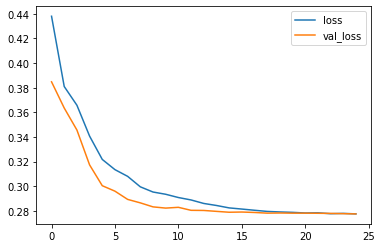

In [51]:
import io
data_info = pd.read_csv(io.BytesIO(uploaded['lending_club_info.csv']))
df = pd.read_csv(io.BytesIO(uploaded['lending_club_loan_two.csv']))

null_count = df.isnull().sum()
null_cent = (df.isnull().sum()/len(df))*100
chk_null_cent = pd.DataFrame({'null_val_count':null_count,'percent':null_cent})
chk_null_cent[chk_null_cent['null_val_count']!=0].sort_values('percent',ascending=False)

df = df.drop(['revol_util','pub_rec_bankruptcies','title','emp_length','emp_title'],axis=1)

avg_acc = df.groupby('total_acc').mean()['mort_acc']

def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return avg_acc[total_acc]
    else:
        return mort_acc

df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

df['term'] = df['term'].apply(lambda x: x[:3])
df['term'] = df['term'].apply(pd.to_numeric) 

df = df.drop(['grade','verification_status','issue_d','purpose'],axis=1)

subgrade_dummies = pd.get_dummies(df['sub_grade'],drop_first=True)
df = pd.concat([df.drop('sub_grade',axis=1),subgrade_dummies],axis=1)

df['home_ownership'] = df['home_ownership'].replace(['NONE','ANY'],'OTHER')
homeowner_dummies = pd.get_dummies(df['home_ownership'],drop_first=True)
df = pd.concat([df.drop('home_ownership',axis=1), homeowner_dummies],axis=1)

df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: int(x[-4:]))

dummies = pd.get_dummies(df[['initial_list_status','application_type']],drop_first=True)
df = df.drop(['initial_list_status','application_type'],axis=1)
df = pd.concat([df, dummies],axis=1)

df['address'] = df['address'].apply(lambda x: int(x[-5:]))

df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})

df = df.drop('loan_status',axis=1)

X = df.drop('loan_repaid',axis=1)
y = df['loan_repaid']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.constraints import max_norm

model = Sequential()

model.add(Dense(78, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')


model.fit(x=X_train,y=y_train,epochs=25,batch_size=512,validation_data=(X_test,y_test))

from tensorflow.keras.models import load_model
model.save('project_model.h5')

losses = pd.DataFrame(model.history.history)
losses[['loss', 'val_loss']].plot()

pred = model.predict_classes(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, pred))